# Histograms

In [157]:
import sys
assert any(c.startswith('/Users/wbeard/Library/Jupyter') for c in sys.argv)

True

In [155]:
sys.argv

['-c',
 '-f',
 '/Users/wbeard/Library/Jupyter/runtime/kernel-b9afa02b-fbc2-4dff-ae95-b5b836a2b4da.json']

In [1]:
# HIDDEN
from boot_utes import add_path, path, reload, run_magics
add_path(
    "..", "/Users/wbeard/repos/fis/fis/", "/Users/wbeard/repos/fis/", "~/repos/myutils/",
)
add_path("/Users/wbeard/repos/dscontrib-moz/src/")

11

In [48]:
assert __name__ == '__main__', __name__

In [84]:

from matplotlib import MatplotlibDeprecationWarning

import dscontrib.wbeard as dwb
from utils.fis_imps import *

exec(pu.DFCols_str)
exec(pu.qexpr_str)
run_magics()
# import utils.en_utils as eu; import data.load_data as ld; exec(eu.sort_dfs_str)

mu.set_import_name(mu)
sns.set_style("whitegrid")
S = Series
D = DataFrame

import dscontrib.wbeard.altair_utils as aau

aau.set_ds(A)

DataFrame.pat = aau.pat

%load_ext autoreload
%autoreload 2

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# HIDDEN
from collections import OrderedDict
from functools import partial, lru_cache, wraps

import altair as A
import pandas as pd
import scipy.stats as sts

from fis.models import hist
import fis.data.load_agg_hists as loh
from fis.utils import bq
import fis.utils.vis as vz

In [4]:
dfh2_ = bq.bq_query(loh.dl_agg_query())
dfh2 = loh.proc_hist_dl(dfh2_)

/Users/wbeard/miniconda3/envs/fis/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
# HIDDEN
# s = dfh2.unq_sites_per_doc
# h = s[0]
# h

# del s, h

In [40]:
# HIDDEN
TEST = 1


def cache_dict(f):
    @lru_cache()
    def tup_f(tup):
        d = dict(tup)
        return f(d)

    @wraps(f)
    def dict_f(dict_arg):
        tuple_arg = tuple(sorted(dict_arg.items()))
#         print(tuple_arg)
        return tup_f(tuple_arg)

    return dict_f


gmean = lambda x: sts.gmean(x + 1e-6)

agg_gmean = partial(
    hist.est_statistic,
    n_hists=100 if TEST else 10_000,
    client_draws=10,
    stat_fn=gmean,
    quantiles=[0.05, 0.5, 0.95],
)
agg_gmean_cache = cache_dict(agg_gmean)

In [41]:
# HIDDEN
def summarize_hist_df(df, hist_srs):
    ps = [agg_gmean_cache(h) for h in hist_srs]
    df = pd.concat([df[["date", "br", "n_cid"]], pd.DataFrame(ps)], axis=1)
    return df


# hdf = summarize_hist_df(dfh2, s)

In [42]:
hist_dfs = OrderedDict(
    [(hcol, summarize_hist_df(dfh2, dfh2[hcol])) for hcol in loh.hist_cols]
)

In [23]:
agg_gmean_cache(ss)

{'p05': 15.813656439576325,
 'p50': 99.79817786417546,
 'p95': 100.00000100000004}

In [33]:
ss = pd.Series(s[0]).sort_index()
samps = hist.est_statistic(ss, stat_fn=gmean, quantiles=None)
# ss

In [34]:
min(samps)

0.39393471489398496

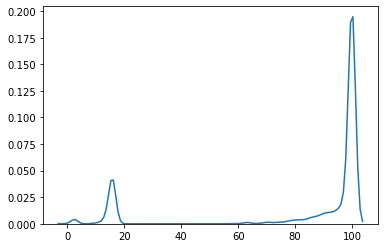

In [35]:
import seaborn as sns

sns.kdeplot(samps)

# How to deal with multimodal

In [49]:
loh.multimodal_histograms

['cycle_collector_slice_during_idle', 'gc_slice_during_idle']

In [54]:
for mc in loh.multimodal_histograms:
    sr = dfh2[mc]
    s = sr[0]
    break
    
samps = hist.est_statistic(s, stat_fn=gmean, quantiles=None)


In [77]:
d2s = pd.concat(
    [
        DataFrame(
            {"samps": hist.est_statistic(h, stat_fn=gmean, quantiles=None)}
        ).assign(date=date)
        for date, h in dfh2[["date", mc]][:2].itertuples(index=False)
    ],
    axis=0,
    ignore_index=True,
)

In [95]:
d2s = d2s.assign(date=lambda df: pd.to_datetime(df.date).dt.date)

In [96]:
d2s[:3]

,samps,date
0,14.664788,2020-06-12
1,98.951927,2020-06-12
2,2.511886,2020-06-12


In [90]:
from vega_datasets import data

data.cars()[:3]

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970-01-01,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970-01-01,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970-01-01,USA


In [117]:
def _pl(pdf, x="Origin", y="Miles_per_Gallon"):
    import altair as alt
    from vega_datasets import data

    h = (
        alt.Chart(pdf)
        .transform_density(y, as_=[y, "density"],
#                            extent=[5, 50],
                           groupby=[x],)
        .mark_area(orient="horizontal")
        .encode(
            y=f"{y}:Q",
            color=f"{x}:N",
            x=alt.X(
                "density:Q",
                stack="center",
                impute=None,
                title=None,
                axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True),
            ),
            column=alt.Column(
                f"{x}:N",
                header=alt.Header(
                    titleOrient="bottom", labelOrient="bottom", labelPadding=0
                ),
            ),
        )
        .properties(width=100)
        .configure_facet(spacing=0)
        .configure_view(stroke=None)
    )
    return h


# _pl(data.cars())
_pl(d2s, x="date", y="samps")

alt.Chart(...)

INFO:tornado.access:304 GET /41a4ad54e2fa4b93473a2b5ed977a699.json (::1) 2.16ms


['-c',
 '-f',
 '/Users/wbeard/Library/Jupyter/runtime/kernel-b9afa02b-fbc2-4dff-ae95-b5b836a2b4da.json']

In [151]:
cky & cin & cga

{'Carroll',
 'Clay',
 'Fayette',
 'Floyd',
 'Franklin',
 'Fulton',
 'Hancock',
 'Henry',
 'Jackson',
 'Jefferson',
 'Johnson',
 'Madison',
 'Marion',
 'Monroe',
 'Montgomery',
 'Morgan',
 'Pike',
 'Pulaski',
 'Union',
 'Warren',
 'Washington',
 'Wayne'}

In [142]:
l[1]

,County,FIPS code[4],County seat[5],Est.[5],Origin[2],Etymology[2],Population[6],Area[5],Map
0,Adair County,1,Columbia,1802,Green County,"John Adair, eighth Governor of Kentucky (1820–24)",19204,"407 sq mi(1,054 km2)",NaN
1,Allen County,3,Scottsville,1815,Barren County and Warren County,"John Allen (1771–1813), hero of the Battle of ...",20384,346 sq mi(896 km2),NaN
2,Anderson County,5,Lawrenceburg,1827,"Franklin County, Washington County and Mercer ...","Richard Clough Anderson, Jr., Kentucky and Uni...",21888,203 sq mi(526 km2),NaN
3,Ballard County,7,Wickliffe,1842,Hickman County and McCracken County,"Bland Ballard (1761–1853), hero of the Battle ...",8240,251 sq mi(650 km2),NaN
4,Barren County,9,Glasgow,1798,Green County and Warren County,"The Barrens, a region of grassland in Kentucky",43148,"491 sq mi(1,272 km2)",NaN
5,Bath County,11,Owingsville,1811,Montgomery County,Medicinal springs located within the county,12206,279 sq mi(723 km2),NaN
6,Bell County,13,Pineville,1867,Harlan County and Knox County,"Joshua Fry Bell, Kentucky legislator (1862–67)",27778,361 sq mi(935 km2),NaN
7,Boone County,15,Burlington,1798,Campbell County,"Daniel Boone (1734–1820), frontiersman",126413,246 sq mi(637 km2),NaN
8,Bourbon County,17,Paris,1785,Fayette County,"House of Bourbon, European royal house",19972,291 sq mi(754 km2),NaN
9,Boyd County,19,Catlettsburg,1860,"Greenup County, Carter County and Lawrence County","Linn Boyd, United States Congressman (1835–37;...",48832,160 sq mi(414 km2),NaN


In [136]:
cin = in_cts.County.str[:-7].pipe(set)
cga = ga_cts.County.str[:-7].pipe(set)

In [138]:
sorted(cin & cga)

['Carroll',
 'Clay',
 'Crawford',
 'DeKalb',
 'Decatur',
 'Fayette',
 'Floyd',
 'Franklin',
 'Fulton',
 'Greene',
 'Hancock',
 'Henry',
 'Jackson',
 'Jasper',
 'Jefferson',
 'Johnson',
 'Madison',
 'Marion',
 'Monroe',
 'Montgomery',
 'Morgan',
 'Newton',
 'Pike',
 'Pulaski',
 'Putnam',
 'Randolph',
 'Union',
 'Warren',
 'Washington',
 'Wayne',
 'White']

In [102]:
_pl(d2s, x="date", y="samps")

alt.Chart(...)

INFO:tornado.access:304 GET /41a4ad54e2fa4b93473a2b5ed977a699.json (::1) 1.79ms


In [100]:
d2s.assign(date=lambda df: pd.to_datetime(df.date)).query("date == '2020-06-12'")

,samps,date
0,14.664788,2020-06-12
1,98.951927,2020-06-12
2,2.511886,2020-06-12
3,15.848932,2020-06-12
4,89.230844,2020-06-12
5,100.000001,2020-06-12
6,99.798178,2020-06-12
7,98.951927,2020-06-12
8,100.000001,2020-06-12
9,100.000001,2020-06-12


In [85]:
def _pl(pdf):
    # color = 'dvers'
    x = "date"
    y = 'samps'

    h = (
        A.Chart(pdf)
        .transform_density(
            y,
            as_=[y, 'density'],
            groupby=[x],
        )
        .mark_area()
        .encode(
            x=A.X(x, title=x),
            y=A.Y(y, title=y, scale=A.Scale(zero=False)),
            # color=color,
            tooltip=[
                # color,
                x,
                y,
            ],
        )
    )

    return h.interactive()

_pl(d2s)

alt.Chart(...)

INFO:tornado.access:200 GET /d320a6919de66caf91f84ae1a092e843.json (::1) 11.02ms


In [78]:
d2s

,samps,date
0,14.664788,2020-06-12
1,98.951927,2020-06-12
2,2.511886,2020-06-12
3,15.848932,2020-06-12
4,89.230844,2020-06-12
5,100.000001,2020-06-12
6,99.798178,2020-06-12
7,98.951927,2020-06-12
8,100.000001,2020-06-12
9,100.000001,2020-06-12


In [ ]:
d2s = {
    date: hist.est_statistic(h, stat_fn=gmean, quantiles=None)
    for date, h in dfh2[['date', mc]][:2].itertuples(index=False)
}

In [71]:
DataFrame(d2s).stack().reset_index(drop=0)

,level_0,level_1,0
0,0,2020-06-12,100.000001
1,0,2020-06-08,15.848932
2,1,2020-06-12,100.000001
3,1,2020-06-08,100.000001
4,2,2020-06-12,15.848932
5,2,2020-06-08,100.000001
6,3,2020-06-12,100.000001
7,3,2020-06-08,100.000001
8,4,2020-06-12,100.000001
9,4,2020-06-08,100.000001


In [65]:
for tup in dfh2[['date', mc]][:2].itertuples(index=False):
    break

tup

Pandas(date=Timestamp('2020-06-12 00:00:00'), cycle_collector_slice_during_idle={0: 33.80704222967141, 75: 1.5132242789535546, 86: 2.0722819665200296, 90: 2.9767725199607815, 92: 3.7645201873241136, 94: 5.261033495356642, 96: 8.730170145163452, 98: 17.054788414903136, 100: 1832.1553999854996, 53: 1.3310201666792048, 30: 1.1246418111069347, 44: 1.2009078568361542, 51: 1.271174523474979, 77: 1.7408445363584728, 81: 2.13782794470227, 84: 1.835788860556756, 88: 2.320310647138757, 71: 1.3963084275840636, 48: 1.351909773379494, 38: 1.4678555958366328, 73: 1.3456782845031758, 42: 1.196541055519369, 26: 1.189526791336755, 36: 1.1329714379877602, 55: 1.2557607048255683, 59: 1.3160716386691687, 61: 1.3099177089331877, 63: 1.303475071797263, 65: 1.4336965910237114, 67: 1.3183284877076302, 79: 1.5945705655717335, 3: 1.138069909106052, 5: 1.0770989089053657, 7: 1.14813708563706, 11: 1.0934393422533064, 32: 1.2207451638528684, 40: 1.1750826503493628, 24: 1.1073439311163573, 28: 1.1718192813591957, 1

In [66]:
a, b = tup


In [57]:
samps

array([100.000001  ,  90.28804621, 100.000001  , ..., 100.000001  ,
        15.35791608, 100.000001  ])

In [56]:
s

{0: 33.80704222967141,
 75: 1.5132242789535546,
 86: 2.0722819665200296,
 90: 2.9767725199607815,
 92: 3.7645201873241136,
 94: 5.261033495356642,
 96: 8.730170145163452,
 98: 17.054788414903136,
 100: 1832.1553999854996,
 53: 1.3310201666792048,
 30: 1.1246418111069347,
 44: 1.2009078568361542,
 51: 1.271174523474979,
 77: 1.7408445363584728,
 81: 2.13782794470227,
 84: 1.835788860556756,
 88: 2.320310647138757,
 71: 1.3963084275840636,
 48: 1.351909773379494,
 38: 1.4678555958366328,
 73: 1.3456782845031758,
 42: 1.196541055519369,
 26: 1.189526791336755,
 36: 1.1329714379877602,
 55: 1.2557607048255683,
 59: 1.3160716386691687,
 61: 1.3099177089331877,
 63: 1.303475071797263,
 65: 1.4336965910237114,
 67: 1.3183284877076302,
 79: 1.5945705655717335,
 3: 1.138069909106052,
 5: 1.0770989089053657,
 7: 1.14813708563706,
 11: 1.0934393422533064,
 32: 1.2207451638528684,
 40: 1.1750826503493628,
 24: 1.1073439311163573,
 28: 1.1718192813591957,
 13: 1.1627458641103632,
 18: 1.07452630339

In [43]:
# HIDE CODE

A.data_transformers.enable('default')

plots = [
    vz.plot_errb(hdf).properties(height=200, width=800, title=h)
    for h, hdf in hist_dfs.items()
]

A.vconcat(*plots)

alt.VConcatChart(...)

In [7]:
# HIDE CODE
# A.data_transformers.enable('json')
A.data_transformers.enable('default')
vz.plot_errb(hdf).properties(height=200, width=800, title=s.name)

alt.LayerChart(...)

# Junk
<!-- # HIDDEN -->

In [8]:
# HIDDEN
turtle = lambda: defaultdict(turtle)

def fn_tuple(full_fn):
    _loc, fn = os.path.split(full_fn)
    locs = _loc.split('/')[2:]
    return locs, fn


def build_dir_dicts(dirs):
    dirs = [
        d.split('/')[2:-1]
        for d in dirs
    ]
    base = fu.AttrDict()
    for bc in base:
        if not bc:
            continue
        
    print(dirs)
    
    
# dirs = glob('../fis/**/', recursive=True)
# build_dir_dicts(dirs)


# fns = sorted([
#     fn_tuple(full_fn) + (full_fn,)
#     for full_fn in glob('../fis/**', recursive=True)
# ], key=lambda x: -len(x[0]))

# fns